The files for analysis are in the "data" folder I have shared with you.

There are 3 internal folders:

(1) DAPI-object_masks: these masks segment the nuclei for each image.
(it is not necessary to perform nucleus segmentation, this has been done already)

(2) sum_projection_zlevels: a sum projection of all z-levels in the image
(original image was in 3D and we have projected it to 2D by summing over all z-levels)

(3) max_projection_zlevels: a max projection of all z-levels in the image
(original image was in 3D and we have projected it to 2D by taking the maximum pixel intensity over all z-levels)

* Each sum and max projection file has 4 channels: BrightField, DAPI, Fibrillarin (Fib), Nucleophosmin (NPM1)

* You will only need the NPM1 channel for this assignment.  We have already used CellPose with the DAPI channel to segment the nuclei and acquire labeled masks.  We would like you to focus on NPM1 quantification for each nucleus.  You can use EITHER the sum or max projections.  We decided to give you 2D images although the original acquisition was in 3D.  So, we project the z-channels to 2 dimensions in 2 different ways and are making both available for you to choose.

The GOAL:

The experiment is to understand how the protein export from the nucleus affects the nucleolar structure. We treated the cells with a protein export inhibitor (LMB) and labeled nucleoli with their structural proteins, Nucleophosmin (NPM1) and Fibillarin (Fib). Interestingly, under the treatment, NPM1 in the nucleus distributes differently between cells. Our goal is trying to find a quantitative way to show the discrepancy of the NPM1 distribution among cells.

Data from: Yi-Shuan Tseng, Holt Lab

This assignment is open ended and we'd like to see your ideas.  Please try to quantify NPM1 in each nucleus in some way.  

Questions: please send a message on slack instead of email if possible.

Email: sarah.keegan@nyulangone.org

DUE DATE: Sunday November 26th at 11:59 pm.

If you are struggling and need some suggestions to get started, slack/email me.  

Some ideas:

Here is a playground from Allen Cell Institute for NPM1 detection:
https://github.com/AllenCell/aics-segmentation/blob/main/lookup_table_demo/playground_npm1.ipynb

Allen cell and structure segmenter (classic image segmentation workflows):
https://www.allencell.org/segmenter.html


In [1]:
# There is a recent bug introduced in Pillow that causes an error in loading PNG files
# We want Pillow < 10.1.0
# You will have to restart your kernal after running the pip install commmand below
import PIL
print('Pillow Version:', PIL.__version__)

# Pin pillow<10.1.0 until imageio is fixed
!pip install Pillow==10.0.0

Pillow Version: 10.0.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Shape of image: (704, 704, 4)
Data type of image: uint16


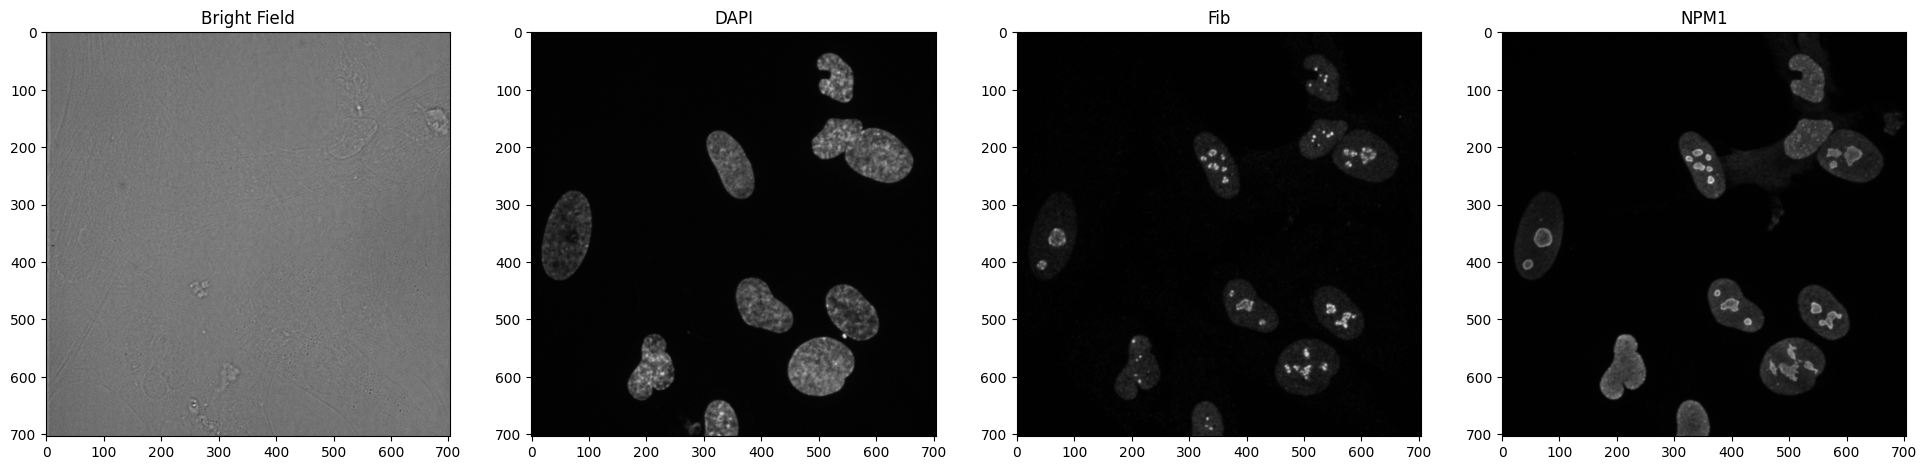

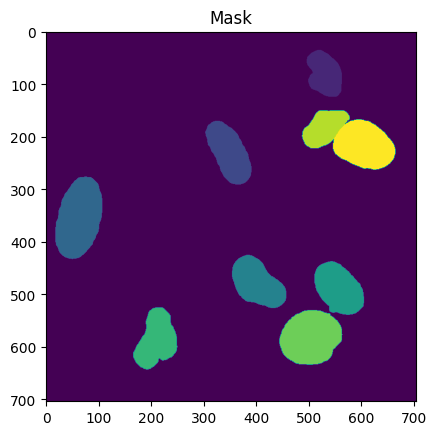

In [3]:
import os
from skimage import io
import matplotlib.pyplot as plt

# Load a mask and the corresponding max projection image
img_dir = "/content/drive/MyDrive/BMI Fall 2024/data/20231104_NPM1_Fib"
dapi_dir = "DAPI-object_masks"
max_proj_dir = "max_projection_zlevels"
sum_proj_dir = "sum_projection_zlevels"

# Let's take a look at a single image and its corresponding mask
img_name = "230405hpne_if_lmb_5hr_60x_001xy05"

dapi_labeled_mask = io.imread(os.path.join(img_dir, dapi_dir, "DAPI_" + img_name + "_seg_cp_masks.png"))
myimg = io.imread(os.path.join(img_dir, max_proj_dir, "MAX_" + img_name + ".tif"))


print("Shape of image:", myimg.shape)
print("Data type of image:", myimg.dtype)

# Show each channel separately:
plt.figure(figsize=(24,7))

plt.subplot(1,4,1)
plt.title("Bright Field")
plt.imshow(myimg[:,:,0], cmap="gray")

plt.subplot(1,4,2)
plt.title("DAPI")
plt.imshow(myimg[:,:,1], cmap="gray")

plt.subplot(1,4,3)
plt.title("Fib")
plt.imshow(myimg[:,:,2], cmap="gray")

plt.subplot(1,4,4)
plt.title("NPM1")
plt.imshow(myimg[:,:,3], cmap="gray")
plt.show()

# labeled mask for segmentation
plt.subplot(1,1,1)
plt.title("Mask")
plt.imshow(dapi_labeled_mask)
plt.show()

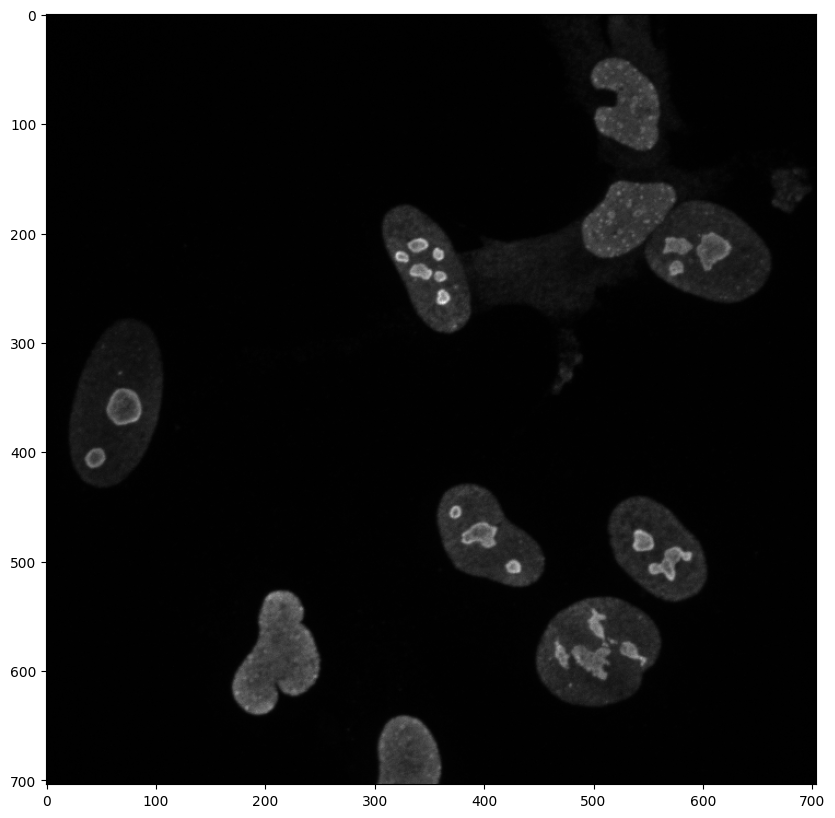

In [4]:
# Let's look at NPM1 more closely
plt.figure(figsize=(10,10))
plt.imshow(myimg[:,:,3], cmap="gray")
plt.show()

Shape of NPM1 channel: (704, 704)
Data type of NPM1 channel: uint16


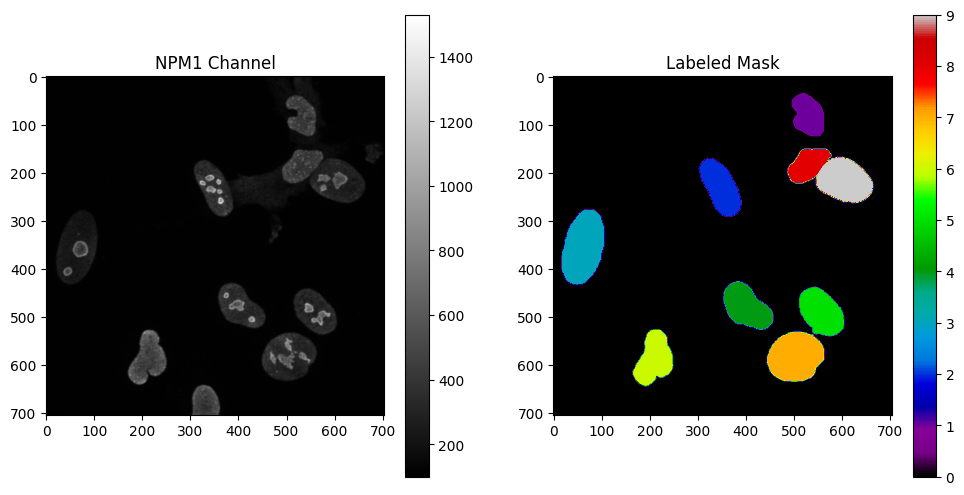

       Nucleus ID  Total Intensity  Mean Intensity  Intensity Variance
count    9.000000     9.000000e+00        9.000000            9.000000
mean     5.000000     2.587771e+06      377.095421        22011.954727
std      2.738613     5.330704e+05       64.102609        11790.248276
min      1.000000     1.815316e+06      259.006862         8369.763595
25%      3.000000     2.411184e+06      352.976724        12845.113666
50%      5.000000     2.702187e+06      372.485618        19649.594830
75%      7.000000     2.717759e+06      408.555640        28160.379526
max      9.000000     3.458143e+06      485.667502        46022.412613
Quantification results saved to /content/drive/MyDrive/BMI Fall 2024/data/20231104_NPM1_Fib/NPM1_quantification.csv


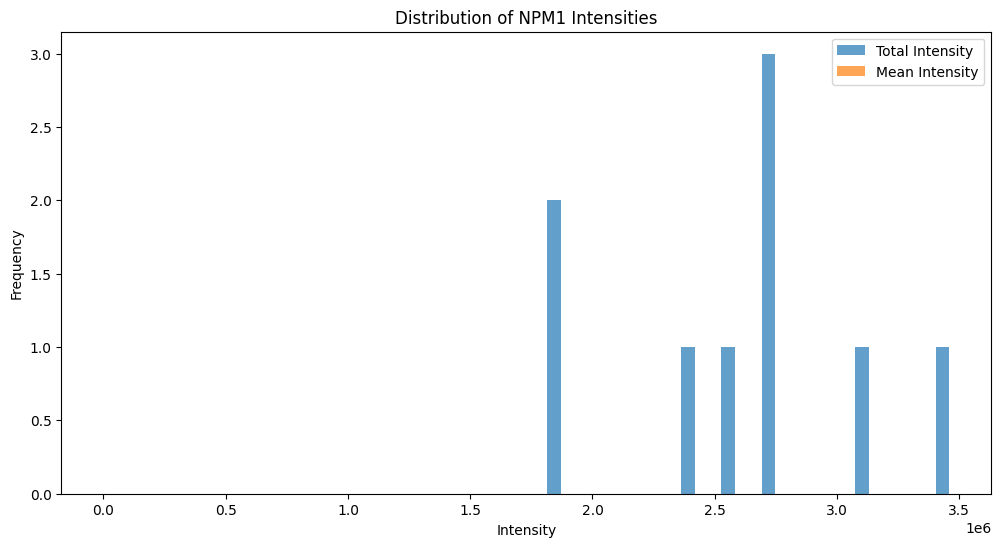

In [5]:
import os
import numpy as np
from skimage import io
from skimage.measure import regionprops, label
import matplotlib.pyplot as plt
import pandas as pd

# paths to your image directories
img_dir = "/content/drive/MyDrive/BMI Fall 2024/data/20231104_NPM1_Fib"
dapi_dir = "DAPI-object_masks"
max_proj_dir = "max_projection_zlevels"

# image name to analyze
img_name = "230405hpne_if_lmb_5hr_60x_001xy05"

# load the labeled mask and the corresponding max projection image
dapi_labeled_mask = io.imread(os.path.join(img_dir, dapi_dir, "DAPI_" + img_name + "_seg_cp_masks.png"))
myimg = io.imread(os.path.join(img_dir, max_proj_dir, "MAX_" + img_name + ".tif"))

# extract the NPM1 channel
npm1_channel = myimg[:, :, 3]

# verify the data
print("Shape of NPM1 channel:", npm1_channel.shape)
print("Data type of NPM1 channel:", npm1_channel.dtype)

# visualize the NPM1 channel and mask
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("NPM1 Channel")
plt.imshow(npm1_channel, cmap="gray")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Labeled Mask")
plt.imshow(dapi_labeled_mask, cmap="nipy_spectral")
plt.colorbar()
plt.show()

# ensure mask is labeled correctly
dapi_labeled_mask = label(dapi_labeled_mask)

# quantify NPM1 intensity for each nucleus
properties = regionprops(dapi_labeled_mask, intensity_image=npm1_channel)

# store results in a list
results = []
for prop in properties:
    label_id = prop.label
    total_intensity = prop.intensity_image[prop.image].sum()  # Total intensity in the nucleus
    mean_intensity = prop.mean_intensity                     # Mean intensity in the nucleus
    intensity_variance = prop.intensity_image[prop.image].var()  # Variance in the intensity

    results.append({
        "Nucleus ID": label_id,
        "Total Intensity": total_intensity,
        "Mean Intensity": mean_intensity,
        "Intensity Variance": intensity_variance
    })

# convert results to a DataFrame
results_df = pd.DataFrame(results)

# show summary statistics
print(results_df.describe())

# save the results for further analysis
results_csv_path = os.path.join(img_dir, "NPM1_quantification.csv")
results_df.to_csv(results_csv_path, index=False)
print(f"Quantification results saved to {results_csv_path}")

# plot intensity metrics
plt.figure(figsize=(12, 6))
plt.hist(results_df["Total Intensity"], bins=30, alpha=0.7, label="Total Intensity")
plt.hist(results_df["Mean Intensity"], bins=30, alpha=0.7, label="Mean Intensity")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.title("Distribution of NPM1 Intensities")
plt.legend()
plt.show()
